# Compare distance metrics to cluster snapshots

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sb

import phasik as pk

## 1. Build temporal network

In [2]:
# load static PPI network
static_net_filepath = "../data/kegg/static_PPI_network_KEGG.adjlist"
static_network = nx.read_adjlist(static_net_filepath)  # networkx Graph object

pk.graph_size_info(static_network)

# load edge time series
edge_activity_filepath = "../data/chen/edge_time_series_normed.csv"
norm = True

# use this for non-normalised time series
# edge_activity_filepath = "data/chen/edge_time_series.csv"
# norm = False

edge_series = pd.read_csv(edge_activity_filepath).transpose()
times = list(edge_series.columns)

# build temporal network

# this function buils a TemporalNetwork, by integrating the edge time series to the static network,
# and setting a constant default weight value for edges for which we have no temporal information
temporal_network = pk.TemporalNetwork.from_static_network_and_edge_timeseries(
    static_network,
    edge_series,
    static_edge_default_weight=1,
    quiet=True,  # if True, prints less information
)

temporal_network_name = f"kegg_chen_normed_{norm}"

A PartiallyTemporalNetwork is created instead.


## 2. Compare clusters for each distance metric

In [3]:
# From scipy's documentation
#
# "Methods ‘centroid’, ‘median’, and ‘ward’ are correctly defined
# only if Euclidean pairwise metric is used. If 'y' is passed as precomputed pairwise distances,
# then it is the user’s responsibility to assure that these distances are in fact Euclidean,
# otherwise the produced result will be incorrect."
#
# -> this means we cannot used Ward as a reference method to test various distance metrics.

In [4]:
# clustering parameters
clustering_method = "average"  # clustering method
n_max_type = "maxclust"  # set number of clusters by maximum number of clusters wanted

# list of distance metrics to compare (for real-valued vectors)
distance_metrics = ["euclidean", "cosine", "manhattan", "chebyshev"]

# for boolean vectors
# distance_metrics = ['jaccard', 'dice']
# all distance metric available (intended for different uses)
# distance_metrics = [
#     'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan', 'braycurtis', 'canberra', 'chebyshev', 'correlation',
#     'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'minkowski', 'rogerstanimoto', 'russellrao',
#     'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule',
# ]

n_max = 5  # max number of clusters
n_max_range = range(2, 12)  # range of numbers of clusters to compute

# plotting parameters
if norm:
    output_directory = "images/chen/normalised/"
else:
    output_directory = "images/chen/"

events_times = [5, 33, 36, 70, 84, 100]
events_labels = ["START", "bud", "ori", "E3", "spn", "mass"]
events = [(time, name, "dashed") for time, name in zip(events_times, events_labels)]

phases = [(0, 35, "G1"), (35, 70, "S"), (70, 78, "G2"), (78, 100, "M")]

time_ticks = range(101, 10)

### 2.1 Compute cluster sets for each distance metric

In [5]:
valid_cluster_sets = []
for distance_metric in distance_metrics:
    try:
        distance_matrix = pk.DistanceMatrix.from_temporal_network(
            temporal_network, distance_metric
        )

        cluster_sets = pk.ClusterSets.from_distance_matrix(
            distance_matrix, n_max_type, n_max_range, clustering_method
        )
        valid_cluster_sets.append((cluster_sets, distance_metric))
    except Exception as e:
        raise e
        print(f"Error when distance_metric = {distance_metric}: {e}")

valid_metrics = [sets[1] for sets in valid_cluster_sets]

### 2.2 Plot across different distance metrics

In [6]:
gridspec_kw = {"width_ratios": [3, 1, 2]}
figsize = (9, 4 * len(valid_cluster_sets))
fig, axs = plt.subplots(
    len(valid_cluster_sets),
    3,
    figsize=figsize,
    gridspec_kw=gridspec_kw,
    sharey="row",
    sharex="col",
)

for i, (cluster_sets, distance_metric) in enumerate(valid_cluster_sets):
    row = (axs[i, 0], axs[i, 1], axs[i, 2])
    cluster_sets.plot_and_format_with_average_silhouettes(
        row, events, phases, time_ticks, coloring="consistent"
    )

    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    fontdict = {"horizontalalignment": "center"}
    axs[i, 1].set_title(
        f"Distance_metric = {distance_metric}",
        fontdict=fontdict,
        fontweight="bold",
        pad=12,
    )

title = (
    temporal_network_name
    + f"\ncluster_method={clustering_method}, cluster_limit_type={n_max_type}"
)
# fig.suptitle(title, y=0.97, weight='bold')

# Save
if output_directory is not None:
    filename = f"{output_directory}/clusters_over_distance_metrics_method{clustering_method}_{pk.slugify(temporal_network_name)}"
#     plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
#     plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")

### 2.4 Compute similarity of clusterings to reference distance metric "Euclidean"

In [7]:
rand_index = pk.rand_index_over_methods_and_sizes(
    valid_cluster_sets, reference_method="euclidean"
)

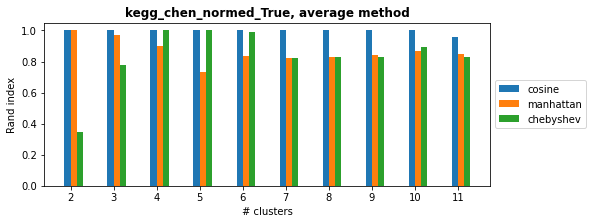

In [8]:
sb.set_palette("tab10")
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

pk.plot_randindex_bars_over_methods_and_sizes(
    valid_cluster_sets, reference_method="euclidean", ax=ax
)

ax.set_ylabel("Rand index")
ax.set_xlabel("# clusters")

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

ax.set_title(f"{temporal_network_name}, {clustering_method} method", weight="bold")

# Save
if output_directory is not None:
    filename = f"{output_directory}/randindex_over_distance_metrics_method_{clustering_method}_{pk.slugify(temporal_network_name)}"
#     plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
#     plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")

plt.show()